In [1]:
import tensorflow as tf
from keras.models import load_model
from pathlib import Path
from art_api import utils, config
import os
from PIL import Image
import numpy as np
import pandas as pd
import wandb
from wandb.keras import WandbCallback
from abc import ABC, abstractmethod
from tensorflow.keras import Sequential, layers, models
print(f"memory usage {tf.config.experimental.get_memory_info('GPU:0')['current'] / 10 ** 9} GB")

%load_ext autoreload

2022-09-20 22:02:53.502595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-20 22:02:53.562173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-20 22:02:53.562481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-20 22:02:53.565017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

memory usage 0.0 GB


 /job:localhost/replica:0/task:0/device:GPU:0 with 5423 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6


In [2]:
print(config.wandb.config)

{'LEARNING_RATE': 0.0001, 'N_EPOCHS': 50, 'BATCH_SIZE': 32, 'DROPOUT_RATE': 0.0, 'IM_SIZE': 256, 'REGULARIZATION_RATE': 0.0, 'N_FILTERS': 6, 'KERNEL_SIZE': 3, 'N_STRIDES': 1, 'POOL_SIZE': 2, 'N_DENSE_1': 100, 'N_DENSE_2': 10}


In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),
    
    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

In [15]:
class Model:
    def __init__(self, datafile = config.DF_PATH):
        self.df = pd.read_csv(datafile)
        #self.model = load_baseline_model()
        
    def load_baseline_model():
        model = Sequential()
        model.add(Rescaling(1./255, input_shape = (config.IM_SIZE, config.IM_SIZE, 3)))

        model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
        model.add(layers.MaxPooling2D(3))

        model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
        model.add(layers.MaxPooling2D(3))

        model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
        model.add(layers.MaxPooling2D(3))

        model.add(layers.Flatten())
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(10, activation='sigmoid'))

        opt = optimizers.Adam(learning_rate=1e-4)
        model.compile(loss='binary_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])
        
        model.summary()

        return model
    
    def split(self, test_size):
        X = np.array(self.df[['Humidity', 'Pressure (millibars)']])
        y = np.array(self.df['Temperature (C)'])
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = test_size, random_state = 42)
    
    def fit(self):
        self.model = self.linear_reg.fit(self.X_train, self.y_train)
    
    def predict(self):
        result = self.linear_reg.predict(self.X_test)
        return result
    
    def preproc(self):
        '''Preprocess for the chosen model'''
    
    def build_model(model):
        '''model can be baseline, vgg16, vgg19, resnet50, ResNet152, ResNet152V2, InceptionV3, InceptionResNetV2, Xception'''
        model = load_resnet152_model()
        model = add_last_layers(model)

        model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(learning_rate=1e-4),
                      metrics=['accuracy'])
        return model

if __name__ == '__main__':
    model_instance = Model()
    #model_instance.split(0.2)
    #model_instance.fit() 
    #print(model_instance.predict())   
    #print("Accuracy: ",     model_instance.model.score(model_instance.X_test, model_instance.y_test))

In [3]:
class BaseModel:

    def __init__(self, cfg):
        self.config = config.wandb.config

    def load_local(self):
        """Loads dataset from local path"""
        df = pd.read_csv(local_path)
        return df

In [4]:
print(config.DF_PATH)

../raw_data/df_yourpaintings.csv


In [5]:
baseline = BaseModel(config.wandb.config)
print(baseline)

In [6]:
df = baseline.load_data(config.DF_PATH)

AttributeError: 'BaseModel' object has no attribute 'load_data'

In [23]:
class BaseModel(ABC):
    '''Abstract Model class that is inherited to all models
    Behaviours:
    Get X and y
    Resize, load as array
    Preprocess input
    Get_config: hyperparameter tuning
    Model: baseline, VGG16, VGG19, ResNet, Inception, Xception
    Unfreeze layer
    Compile
    Fit
    Evaluate: accuracy, classification report, confusion matrix
    Predict with different thresholds (0.5, mean, median)
    Save model
    Df to csv
    '''
    def __init__(self, cfg):
        self.config = config.wandb.config

    @abstractmethod
    def load_data(self):
        self.df=DataLoader.load_cloud()
        return df

    @abstractmethod
    def build(self):
        pass

    @abstractmethod
    def train(self):
        pass

    @abstractmethod
    def evaluate(self):
        pass

In [22]:
baseline = BaseModel(config.wandb.config)

TypeError: Can't instantiate abstract class BaseModel with abstract methods build, evaluate, load_data, train

In [5]:
df = baseline.load_data()

NameError: name 'baseline' is not defined

In [ ]:
def load_baseline_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(256,256,3)))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [15]:
MODEL_PATH = Path("../models/vgg16_bal")
PATH_NGS = Path("../raw_data/aws10k")
PATH_NGS_SM = Path("../raw_data/aws10k_sm")

In [16]:
model = load_model(MODEL_PATH)

In [38]:
print(type(file))

<class 'str'>


In [2]:
lst_filename = []
lst_idx = []
x_ngs = []

In [3]:
for file in os.listdir("../raw_data/aws10k_sm"):
    lst_filename.append(str(file))
    idx = file[:file.rfind(".")-1]
    lst_idx.append(idx)

In [4]:
lst_filename

['2003-03474.jpg',
 '2015-00425.jpg',
 '2020-00439.jpg',
 '2006-00072.jpg',
 '2008-06715.jpg',
 '2013-00179.jpg',
 '2008-06890.jpg',
 '2003-03500.jpg',
 '2019-00695.jpg',
 'P-0371.jpg',
 'P-0354-L.jpg',
 '1995-01952.jpg',
 '2013-00268.jpg',
 '2011-02043.jpg',
 'GI-0282-(OT).jpg',
 '1994-00412.jpg',
 '2011-00127.jpg',
 'P-1124.jpg',
 '2001-02509.jpg',
 '2009-03214.jpg',
 '1992-00288.jpg',
 '2016-00458.jpg',
 '1992-00250.jpg',
 '2003-03274.jpg',
 '2017-00001.jpg',
 'P-1003.jpg',
 'P-0364.jpg',
 'P-0410.jpg',
 '1994-04518.jpg',
 '2010-00864.jpg',
 'GI-0053.jpg',
 'GI-0544.jpg',
 'P-1077.jpg',
 '1993-01418.jpg',
 '2011-01575.jpg',
 '2009-03408.jpg',
 'P-0321.jpg',
 'P-0400.jpg',
 '2003-03097.jpg',
 'P-0427.jpg',
 '2003-03040.jpg',
 '1999-01637.jpg',
 '1994-04524.jpg',
 '2009-03425.jpg',
 '2013-00292.jpg',
 '2003-04081.jpg',
 'P-1207.jpg',
 '2009-03202.jpg',
 '2003-03947.jpg',
 'P-1009.jpg',
 '2001-03345.jpg',
 '2009-03549.jpg',
 '2001-03312.jpg',
 'P-1161.jpg',
 'P-0069.jpg',
 '2003-04128.

In [7]:
# load all images in a directory
from os import listdir
from matplotlib import image

In [8]:
data = []
fname = []

In [9]:
for file in listdir("../raw_data/aws10k_sm"):
    img = Image.open("../raw_data/aws10k_sm/" + file)
    img_array = np.asarray(img)
    data.append(img_array)
    fname.append(file)

In [11]:
img_dir = listdir("../raw_data/aws10k_sm")

In [12]:
from PIL import Image
img = Image.open("../raw_data/aws10k_sm/" + file).convert('RGB')
 # a line from my program
positive_images_array = np.array([np.array(Image.open("../raw_data/aws10k_sm/" + img).convert('RGB')) for img in img_dir])

In [13]:
positive_images_array.shape

(4952, 256, 256, 3)

In [37]:
y_pred = model.predict(positive_images_array)

155/155 [==============================] - 14s 93ms/step


In [18]:
y_pred.shape

(4952, 10)

In [172]:
np.mean(y_pred)

0.08370335

In [171]:
np.median(y_pred)

0.041988567

In [19]:
pred_half = (model.predict(positive_images_array) > 0.5).astype("int32")
pred_mean = (model.predict(positive_images_array) > np.mean(y_pred)).astype("int32")
pred_median = (model.predict(positive_images_array) > np.median(y_pred)).astype("int32")

155/155 [==============================] - 14s 94ms/step


In [39]:
df_pred_half = pd.concat([pd.DataFrame(fname), pd.DataFrame(pred_half), pd.DataFrame(y_pred)], axis=1)
df_pred_half.columns = ["filename", "aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train", "proba_aeroplane", "proba_bird", "proba_boat", "proba_chair", "proba_cow", "proba_diningtable", "proba_dog", "proba_horse", "proba_sheep", "proba_train"]
df_pred_half.sum()
df_pred_half.to_csv('df_pred_0.5.csv')

In [40]:
df_pred_mean = pd.concat([pd.DataFrame(fname), pd.DataFrame(pred_mean), pd.DataFrame(y_pred)], axis=1)
df_pred_mean.columns = ["filename", "aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train", "proba_aeroplane", "proba_bird", "proba_boat", "proba_chair", "proba_cow", "proba_diningtable", "proba_dog", "proba_horse", "proba_sheep", "proba_train"]
df_pred_mean.sum()
df_pred_mean.to_csv('df_pred_mean.csv')

In [22]:
df_pred_median = pd.concat([pd.DataFrame(fname), pd.DataFrame(pred_median)], axis=1)
df_pred_median.columns = ["filename", "aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
df_pred_median.sum()

filename       2003-03474.jpg2015-00425.jpg2020-00439.jpg2006...
aeroplane                                                   3754
bird                                                        4398
boat                                                        2691
chair                                                       2097
cow                                                         1635
diningtable                                                 2915
dog                                                         2325
horse                                                       1900
sheep                                                       1492
train                                                       1553
dtype: object

In [143]:
horse_indices = np.argsort(y_pred[:, 7])

In [164]:
horse_indices[0]

3019

In [51]:
df_pred_mean

filename  aeroplane  bird  boat  chair  cow  diningtable  dog  \
0     2003-03474.jpg          0     1     0      0    0            0    0   
1     2015-00425.jpg          1     0     0      0    0            0    0   
2     2020-00439.jpg          0     1     1      0    1            0    0   
3     2006-00072.jpg          0     1     1      0    0            0    0   
4     2008-06715.jpg          1     1     0      0    0            0    0   
...              ...        ...   ...   ...    ...  ...          ...  ...   
4947  2010-00819.jpg          0     0     1      0    0            0    0   
4948  2010-03316.jpg          0     1     0      0    0            1    0   
4949  2003-02701.jpg          1     1     0      0    0            1    0   
4950  2016-00325.jpg          1     1     1      0    1            0    0   
4951      P-0382.jpg          1     1     1      1    0            1    1   

      horse  sheep  ...  proba_aeroplane  proba_bird  proba_boat  proba_chair  \
0         0      0  ...         0.057100    0.115602    0.022458     0.011131   
1         0      0  ...         0.927587    0.014692    0.031851     0.028051   
2         1      1  ...         0.074816    0.149333    0.140324     0.021728   
3         1      0  ...         0.038987    0.091817    0.176288     0.006569   
4         0      0  ...         0.273896    0.173405    0.060928     0.028372   
...     ...    ...  ...              ...         ...         ...          ...   
4947      0      0  ...         0.010144    0.062306    0.102744     0.032803   
4948      0      0  ...         0.045614    0.094970    0.034476     0.042242   
4949      0      0  ...         0.374418    0.084787    0.001133     0.019723   
4950      0      0  ...         0.109566    0.166136    0.218753     0.056441   
4951      1      1  ...         0.113741    0.191502    0.260610     0.095335   

      proba_cow  proba_diningtable  proba_dog  proba_horse  proba_sheep  \
0      0.001238           0.029812   0.004650     0.004100     0.003376   
1      0.003215           0.016549   0.013826     0.006009     0.008551   
2      0.118080           0.016893   0.052079     0.145423     0.093966   
3      0.008299           0.024861   0.027147     0.135091     0.004603   
4      0.014653           0.071248   0.017941     0.015544     0.017100   
...         ...                ...        ...          ...          ...   
4947   0.010737           0.048094   0.014666     0.004677     0.008896   
4948   0.008203           0.217610   0.016231     0.015145     0.011259   
4949   0.001089           0.186909   0.005702     0.001568     0.000325   
4950   0.124987           0.074142   0.033548     0.055098     0.029278   
4951   0.064853           0.104304   0.098417     0.128518     0.087863   

      proba_train  
0        0.003755  
1        0.012171  
2        0.097977  
3        0.291157  
4        0.016036  
...           ...  
4947     0.012457  
4948     0.012091  
4949     0.000295  
4950     0.049867  
4951     0.056022  

[4952 rows x 21 columns]

In [53]:
df_pred_mean.columns

Index(['filename', 'aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable',
       'dog', 'horse', 'sheep', 'train', 'proba_aeroplane', 'proba_bird',
       'proba_boat', 'proba_chair', 'proba_cow', 'proba_diningtable',
       'proba_dog', 'proba_horse', 'proba_sheep', 'proba_train'],
      dtype='object')

In [56]:
proba_max = df_pred_mean[['proba_aeroplane', 'proba_bird',
       'proba_boat', 'proba_chair', 'proba_cow', 'proba_diningtable',
       'proba_dog', 'proba_horse', 'proba_sheep', 'proba_train']].idxmax()

In [65]:
proba_max[1]

3889

In [67]:
lst_img = []

In [69]:
for i in proba_max:
    lst_img.append(df_pred_mean['filename'].iloc[i])

In [70]:
lst_img

['2015-00425.jpg',
 'P-0353-G.jpg',
 '2019-00022.jpg',
 '2003-03689.jpg',
 '2017-00039.jpg',
 '1994-04138.jpg',
 '2003-03791.jpg',
 'P-0206.jpg',
 '2015-00429.jpg',
 '2018-00052.jpg']

In [169]:
img = Image.open("../raw_data/2014-00321-ngs-o5.jpg")
img_array = np.asarray(img)

In [171]:
img_array.shape

(964, 1280, 3)

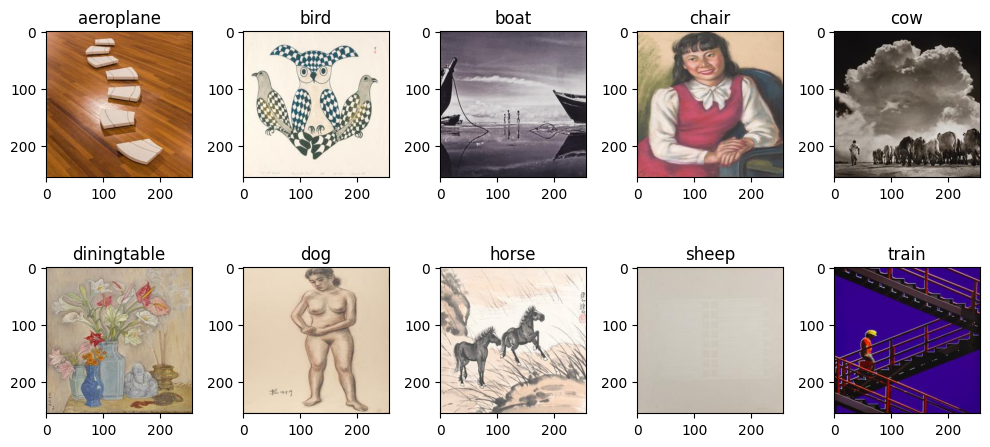

In [167]:
import matplotlib.pyplot as plt

#define subplots
#fig, ax = plt.subplots(2, 5)
fig, ax = plt.subplots(2,5, figsize=(10,5)) 
plt.tight_layout()
#define subplot titles
ax[0, 0].set_title('aeroplane')
ax[0, 0].imshow(top_array[0])
ax[0, 1].set_title('bird')
ax[0, 1].imshow(top_array[1])
ax[0, 2].set_title('boat')
ax[0, 2].imshow(top_array[2])
ax[0, 3].set_title('chair')
ax[0, 3].imshow(top_array[3])
ax[0, 4].set_title('cow')
ax[0, 4].imshow(top_array[4])
ax[1, 0].set_title('diningtable')
ax[1, 0].imshow(top_array[5])
ax[1, 1].set_title('dog')
ax[1, 1].imshow(top_array[6])
ax[1, 2].set_title('horse')
ax[1, 2].imshow(top_array[7])
ax[1, 3].set_title('sheep')
ax[1, 3].imshow(top_array[8])
ax[1, 4].set_title('train')
ax[1, 4].imshow(top_array[9])
plt.tight_layout()
#plt.subplot(2, 3, 1)
#axarr[i,j].imshow(vectors[i][j])

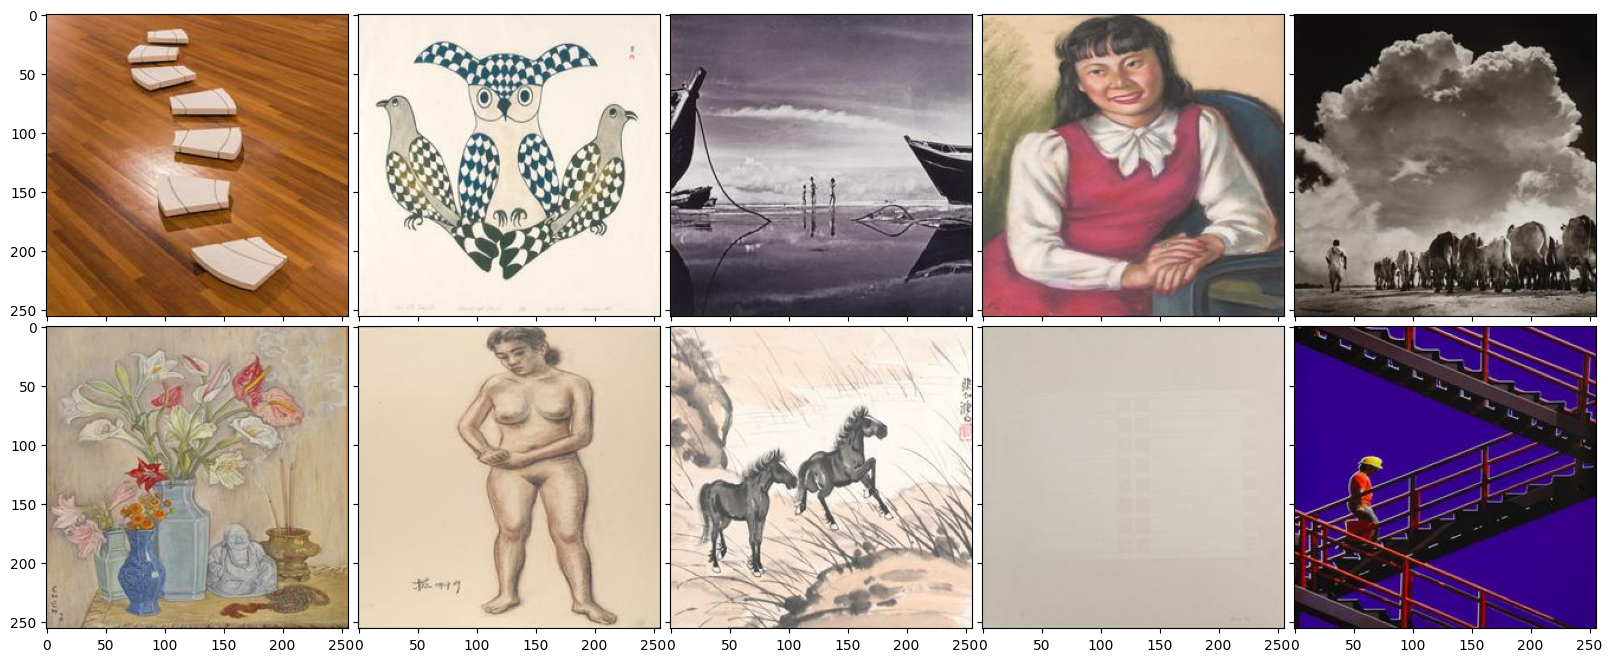

TypeError: 'Axes' object is not subscriptable

In [146]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, top_array):
    ax.imshow(im)
    #ax.set_title('aeroplane')

plt.show()

ax[0, 1].set_title('First Subplot')
ax[0, 1].set_title('Second Subplot')
ax[1, 0].set_title('Third Subplot')
ax[1, 1].set_title('Fourth Subplot')

In [131]:
top_array = np.array([np.array(Image.open("../raw_data/aws10k_sm/" + i).convert('RGB')) for i in lst_img])

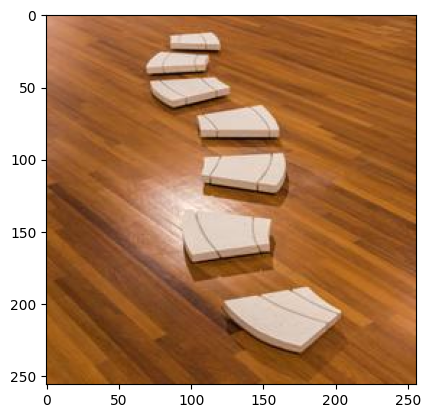

In [151]:
plt.imshow(top_array[0])

In [133]:
def show_images():
    n: int = len(images)
    f = plt.figure()
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)

TypeError: Invalid shape (10, 256, 256, 3) for image data

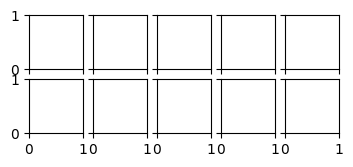

In [138]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [top_array]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

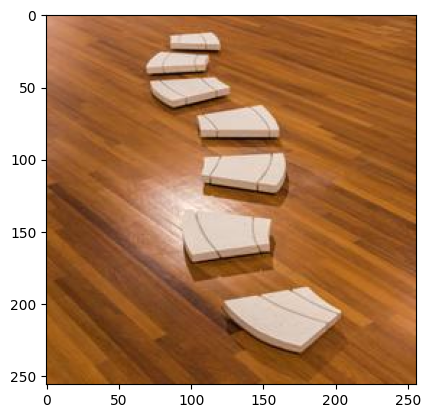

In [136]:
plt.imshow(top_array[0])

In [71]:
for i in lst_img:
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
#    Image.open("../raw_data/aws10k_sm/P-0206.jpg").convert('RGB')
    plt.imshow(image)

2015-00425.jpg
P-0353-G.jpg
2019-00022.jpg
2003-03689.jpg
2017-00039.jpg
1994-04138.jpg
2003-03791.jpg
P-0206.jpg
2015-00429.jpg
2018-00052.jpg


In [84]:
from matplotlib import pyplot as plt
columns=5

NameError: name 'vectors' is not defined

<Figure size 640x480 with 0 Axes>

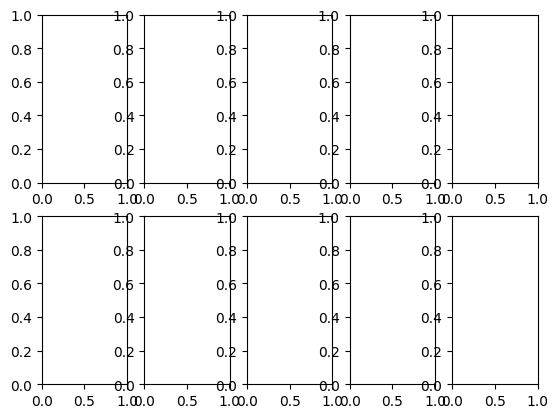

In [89]:
plt.figure()
f, axarr = plt.subplots(2,5, figsize=(10,10)) 

for i in range(5):
    for j in range(2):
        axarr[i,j].imshow(vectors[i][j])

In [113]:
lst_img[0]

'2015-00425.jpg'

In [120]:
["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]

['aeroplane',
 'bird',
 'boat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'sheep',
 'train']

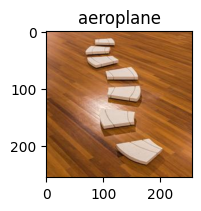

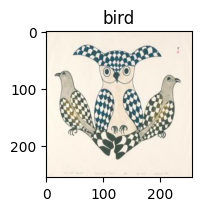

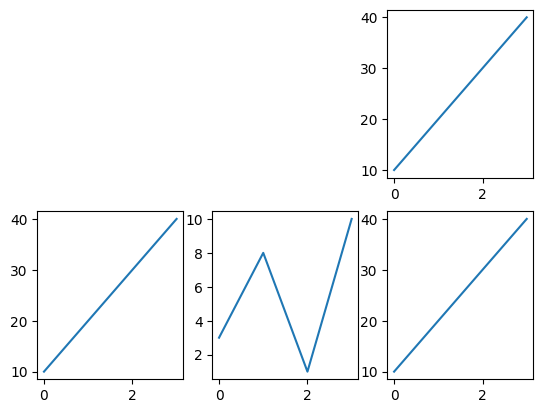

In [127]:
plt.subplot(2, 3, 1)
image = "../raw_data/aws10k_sm/" + lst_img[0]
plt.imshow(plt.imread(image))
plt.title("aeroplane")
plt.show()

plt.subplot(2, 3, 2)
image = "../raw_data/aws10k_sm/" + lst_img[1]
plt.imshow(plt.imread(image))
plt.title("bird")
plt.show()

plt.subplot(2, 3, 3)
plt.plot(x,y)

x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(2, 3, 4)
plt.plot(x,y)

x = np.array([0, 1, 2, 3])
y = np.array([3, 8, 1, 10])

plt.subplot(2, 3, 5)
plt.plot(x,y)

x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(2, 3, 6)
plt.plot(x,y)

plt.show()

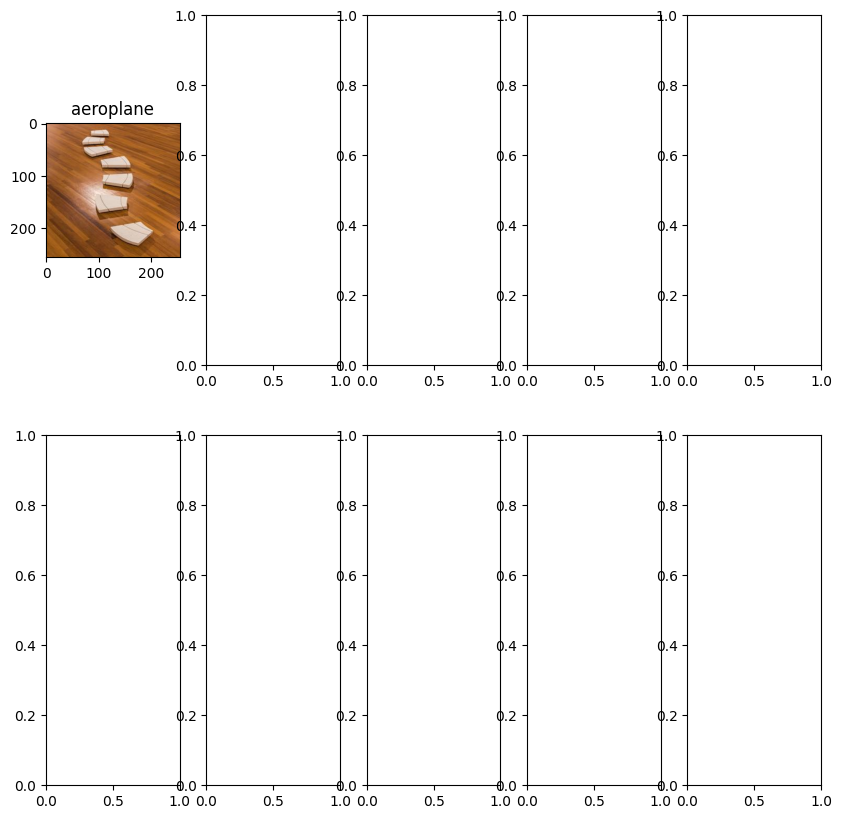

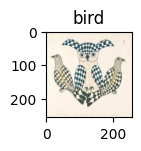

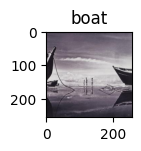

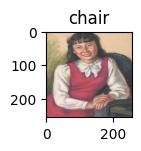

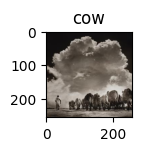

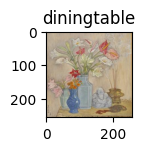

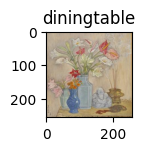

In [130]:
# Start a figure
fig, axs = plt.subplots(2, 5, figsize=(10,10)) # axs is a (1,2) nd-array
# First subplot
plt.subplot(2,5,1)
image = "../raw_data/aws10k_sm/" + lst_img[0]
plt.imshow(plt.imread(image))
plt.title("aeroplane")
plt.show()
# # Second subplot
plt.subplot(2,5,2)
image = "../raw_data/aws10k_sm/" + lst_img[1]
plt.imshow(plt.imread(image))
plt.title("bird")
plt.show()
# # Second subplot
plt.subplot(2,5,3)
image = "../raw_data/aws10k_sm/" + lst_img[2]
plt.imshow(plt.imread(image))
plt.title("boat")
plt.show()
# # Second subplot
plt.subplot(2,5,4)
image = "../raw_data/aws10k_sm/" + lst_img[3]
plt.imshow(plt.imread(image))
plt.title("chair")
plt.show()
# # Second subplot
plt.subplot(2,5,5)
image = "../raw_data/aws10k_sm/" + lst_img[4]
plt.imshow(plt.imread(image))
plt.title("cow")
plt.show()
# # Second subplot
plt.subplot(2,5,6)
image = "../raw_data/aws10k_sm/" + lst_img[5]
plt.imshow(plt.imread(image))
plt.title("diningtable")
plt.show()
# # Second subplot
plt.subplot(2,5,6)
image = "../raw_data/aws10k_sm/" + lst_img[5]
plt.imshow(plt.imread(image))
plt.title("diningtable")
plt.show()
# plt.subplot(1,2,2) 
# plt.plot(years_x, total_y, label="total", c='black')
# plt.title("all energies")
# # Global figure methods
# plt.suptitle('US electricity CO2 emissions')
# plt.show()

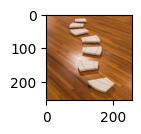

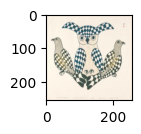

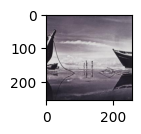

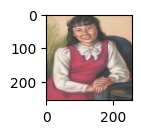

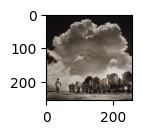

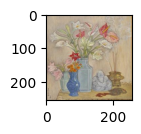

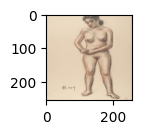

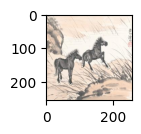

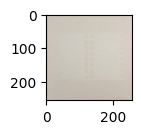

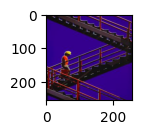

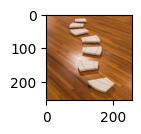

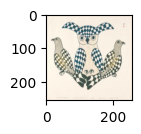

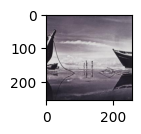

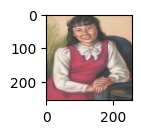

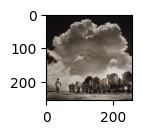

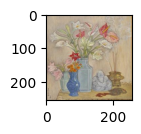

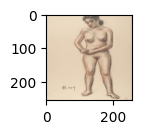

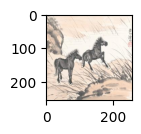

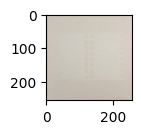

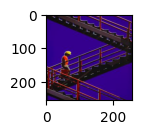

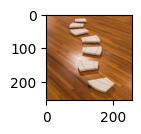

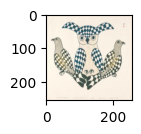

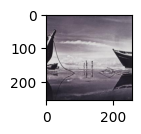

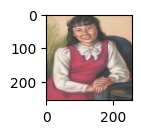

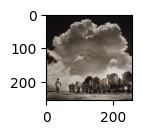

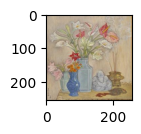

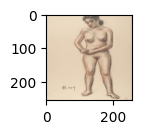

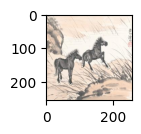

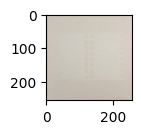

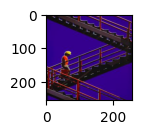

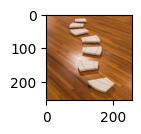

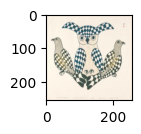

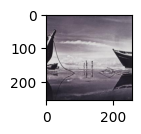

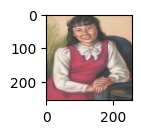

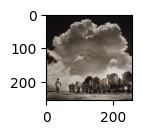

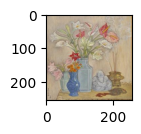

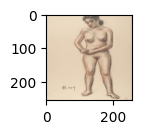

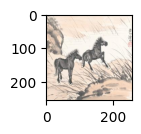

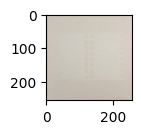

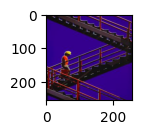

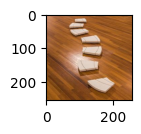

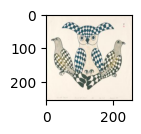

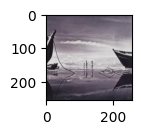

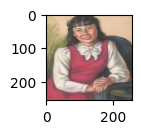

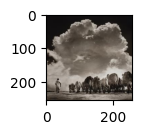

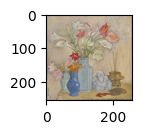

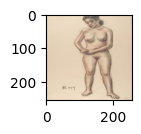

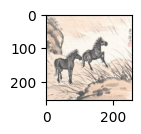

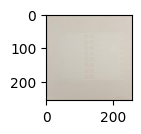

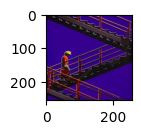

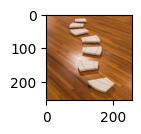

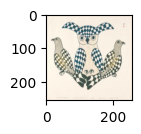

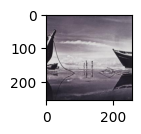

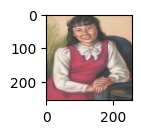

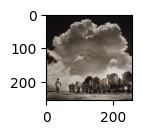

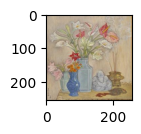

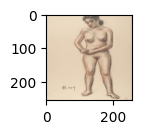

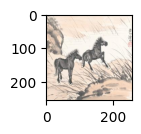

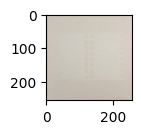

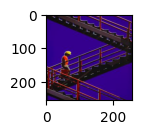

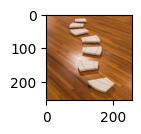

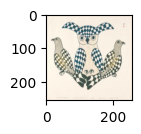

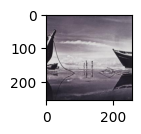

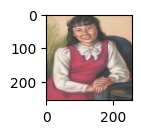

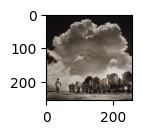

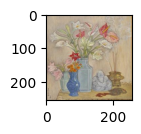

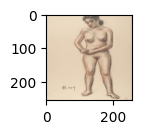

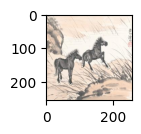

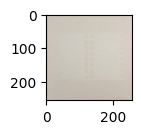

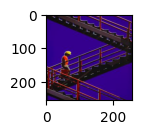

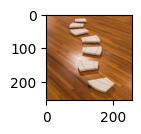

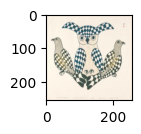

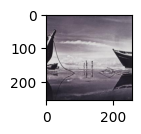

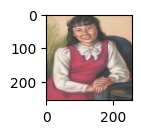

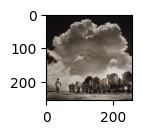

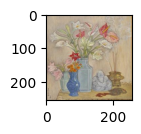

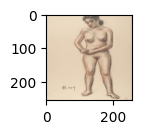

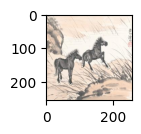

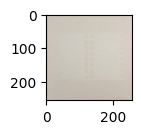

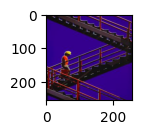

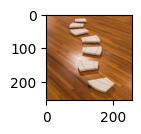

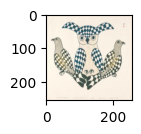

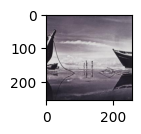

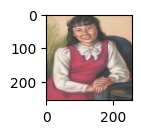

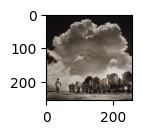

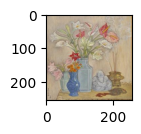

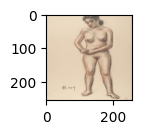

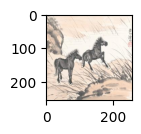

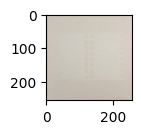

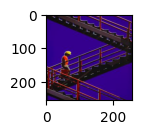

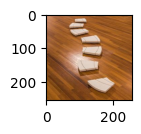

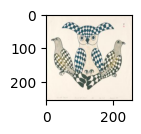

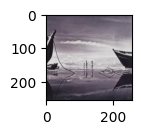

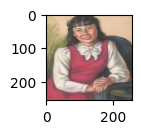

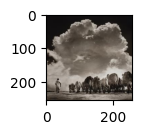

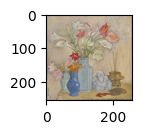

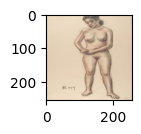

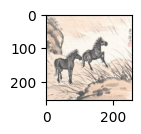

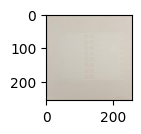

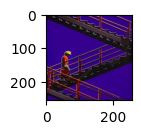

In [110]:
counter = 0
for i in range(1,11):
    for img in lst_img:
        image = "../raw_data/aws10k_sm/" + img
        plt.subplot(2, 5, i)
        plt.imshow(plt.imread(image))
        plt.show()
        #counter += 1

In [ ]:
plt.subplot(2, 5, 1)
plt.imshow(data, cmap="Blues_r")
plt.subplot(1, 4, 2)
plt.imshow(data, cmap="Accent_r")
plt.subplot(1, 4, 3)
plt.imshow(data, cmap="terrain_r")
plt.subplot(1, 4, 4)
plt.imshow(data, cmap="twilight_shifted_r")
plt.show()

In [103]:
ax.imshow(image)

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

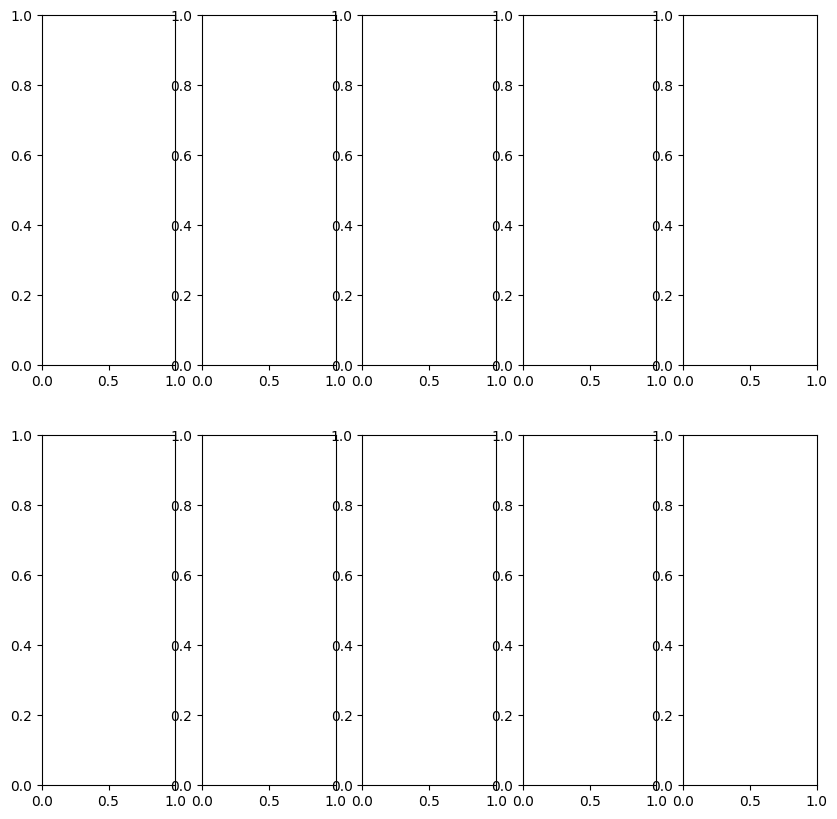

In [104]:
fig, axs = plt.subplots(2, 5, figsize=(10,10)) # axs is a (1,2) nd-array

# First subplot
axs[0].imshow(image)
axs[0].set_title('aeroplane')
axs[0].legend()
# Second subplot
axs[1].plot(years_x, total_y, c='black')
axs[1].set_title('all energies')
# Global figure methods
plt.suptitle('US electricity CO2 emissions')
plt.show()

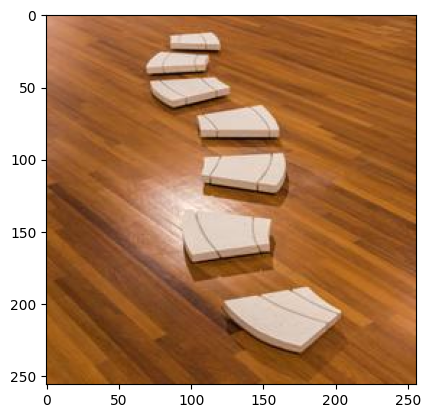

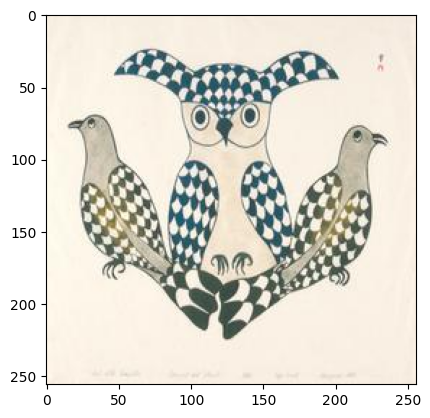

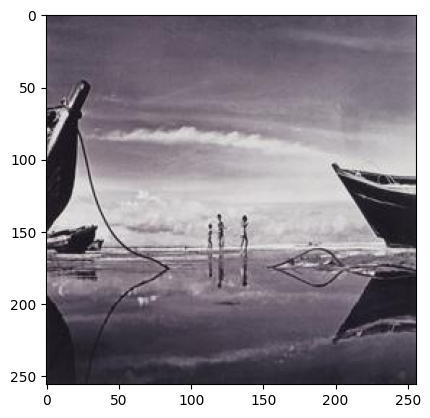

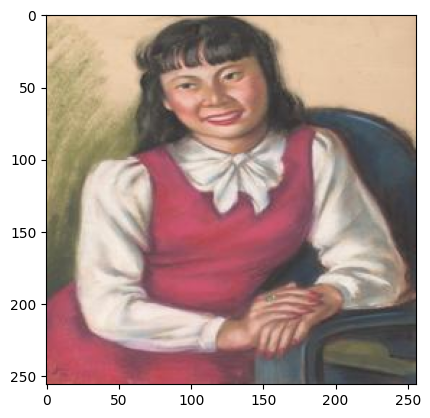

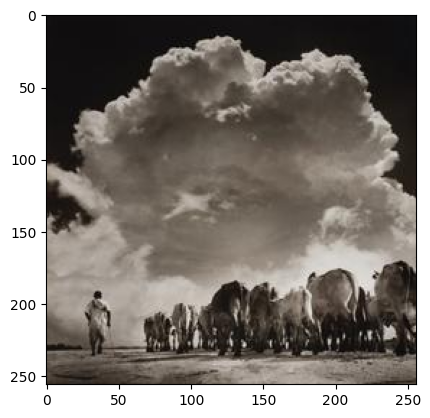

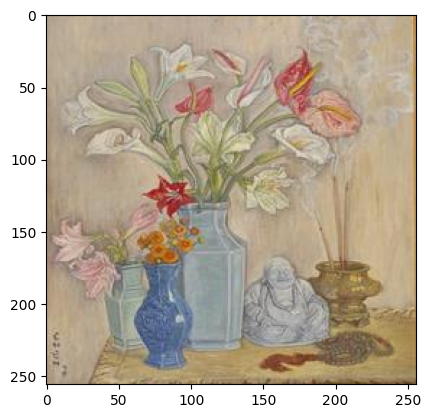

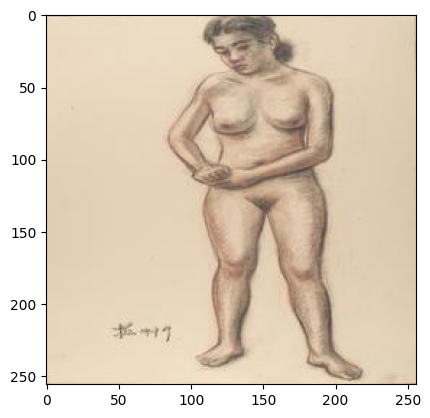

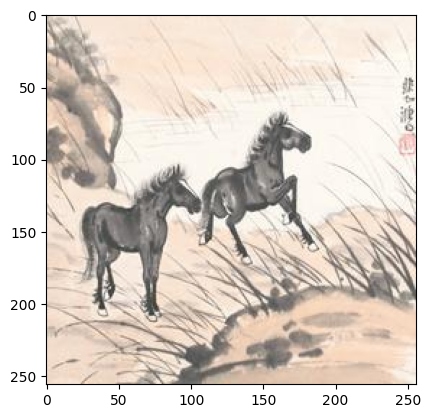

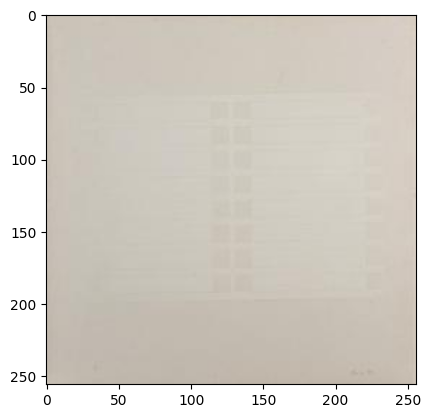

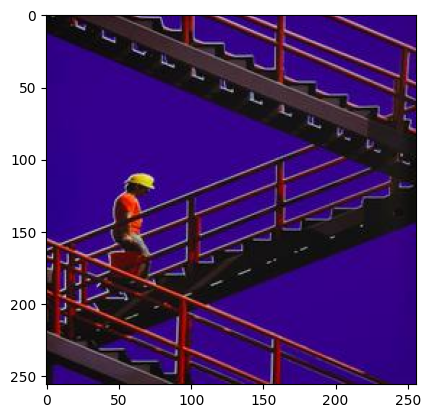

In [91]:
#fig, axs = plt.subplots(2, 5, figsize=(10,10))
for i in lst_img:
    image = "../raw_data/aws10k_sm/" + i
    plt.imshow(plt.imread(image))
    plt.show()
#    Image.open(image).convert('RGB')
#    plt.imshow(image)

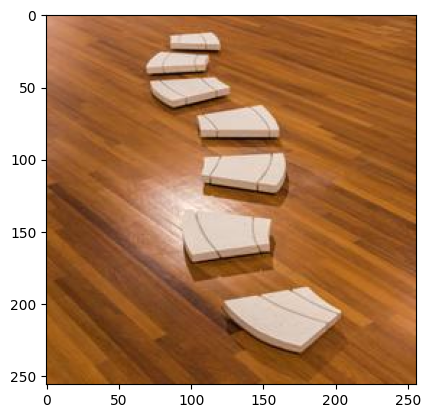

In [82]:
plt.imshow(plt.imread("../raw_data/aws10k_sm/2015-00425.jpg"))

TypeError: Image data of dtype <U36 cannot be converted to float

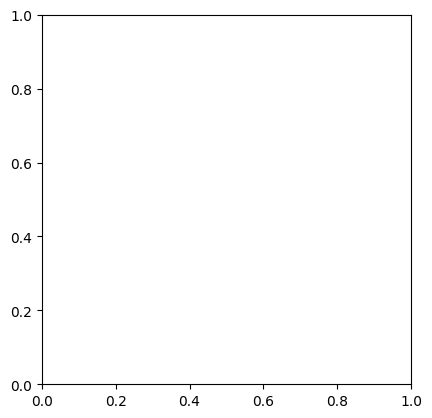

In [81]:
plt.imshow("../raw_data/aws10k_sm/2015-00425.jpg")

In [ ]:
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap, os

def display_images(
    images: [PilImage], 
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size); 

In [61]:
df_pred_mean.iloc[1]

filename             2015-00425.jpg
aeroplane                         1
bird                              0
boat                              0
chair                             0
cow                               0
diningtable                       0
dog                               0
horse                             0
sheep                             0
train                             0
proba_aeroplane            0.927587
proba_bird                 0.014692
proba_boat                 0.031851
proba_chair                0.028051
proba_cow                  0.003215
proba_diningtable          0.016549
proba_dog                  0.013826
proba_horse                0.006009
proba_sheep                0.008551
proba_train                0.012171
Name: 1, dtype: object

In [165]:
fname[3019]

'2013-00259.jpg'

In [167]:
for i in range(horse_indices[50]):
    file = fname[i]
    print(file)
#    img = Image.open("../raw_data/aws10k_sm/" + file).convert('RGB')
#    plt.imshow(img)

#img


2003-03474.jpg
2015-00425.jpg
2020-00439.jpg
2006-00072.jpg
2008-06715.jpg
2013-00179.jpg
2008-06890.jpg
2003-03500.jpg
2019-00695.jpg
P-0371.jpg
P-0354-L.jpg
1995-01952.jpg
2013-00268.jpg
2011-02043.jpg
GI-0282-(OT).jpg
1994-00412.jpg
2011-00127.jpg
P-1124.jpg
2001-02509.jpg
2009-03214.jpg
1992-00288.jpg
2016-00458.jpg
1992-00250.jpg
2003-03274.jpg
2017-00001.jpg
P-1003.jpg
P-0364.jpg
P-0410.jpg
1994-04518.jpg
2010-00864.jpg
GI-0053.jpg
GI-0544.jpg
P-1077.jpg
1993-01418.jpg
2011-01575.jpg
2009-03408.jpg
P-0321.jpg
P-0400.jpg
2003-03097.jpg
P-0427.jpg
2003-03040.jpg
1999-01637.jpg
1994-04524.jpg
2009-03425.jpg
2013-00292.jpg
2003-04081.jpg
P-1207.jpg
2009-03202.jpg
2003-03947.jpg
P-1009.jpg
2001-03345.jpg
2009-03549.jpg
2001-03312.jpg
P-1161.jpg
P-0069.jpg
2003-04128.jpg
2003-03570.jpg
P-1174.jpg
1994-04546.jpg
P-0214.jpg
2001-03421.jpg
2015-00330.jpg
2011-01082.jpg
1993-01406.jpg
2001-03385.jpg
2017-00856.jpg
2000-09132.jpg
2012-00735.jpg
2009-03347.jpg
P-0329.jpg
P-0421.jpg
2011-0159

In [149]:
fname[1606]

'2010-00759.jpg'

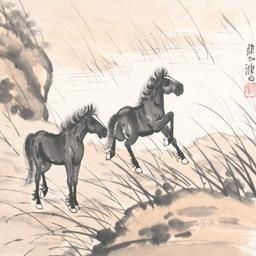

In [41]:
img_a = Image.open("../raw_data/aws10k_sm/P-0206.jpg").convert('RGB')
img_a

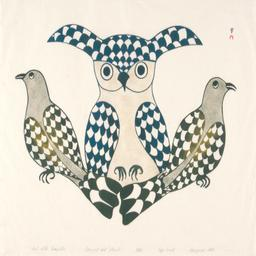

In [49]:
img_a = Image.open("../raw_data/aws10k_sm/P-0353-G.jpg").convert('RGB')
img_a

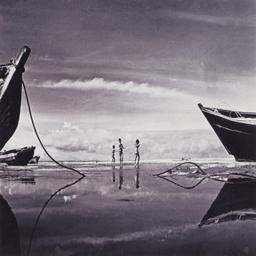

In [50]:
img_a = Image.open("../raw_data/aws10k_sm/2019-00022.jpg").convert('RGB')
img_a

TypeError: Image data of dtype <U36 cannot be converted to float

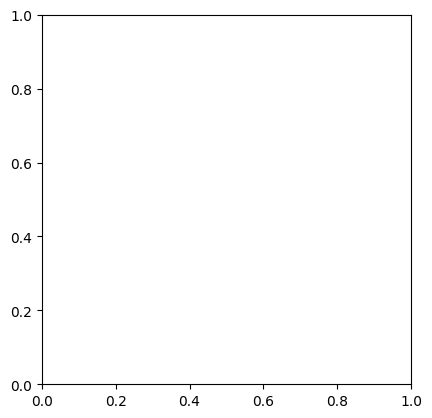

In [139]:
plt.imshow("../raw_data/aws10k_sm/2012-00473.jpg")

In [142]:
horse = y_pred[y_pred[:, 7].argsort()]


In [127]:
aeroplane.shape

(4952, 10)

TypeError: Invalid shape (4952,) for image data

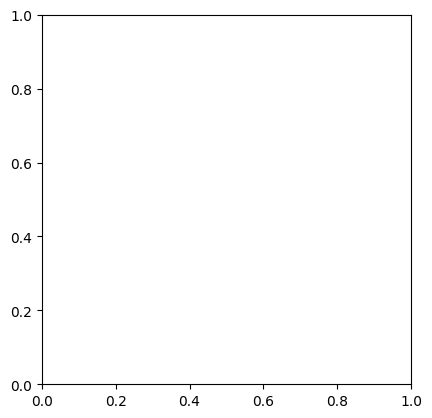

In [128]:
plt.imshow(aeroplane[:,0])

In [114]:
img_X = np.array(data)

/tmp/ipykernel_1212/4280267835.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img_X = np.array(data)


ValueError: could not broadcast input array from shape (256,256,3) into shape (256,256)

In [97]:
from os import listdir
from matplotlib import image
# load all images in a directory
loaded_images = list()
for filename in listdir("../raw_data/aws10k_sm"):
    img_data = image.imread('../raw_data/aws10k_sm/' + filename)
    loaded_images.append(img_data)
    print('> loaded %s %s' % (filename, img_data.shape))

> loaded 2003-03474.jpg (256, 256, 3)
> loaded 2015-00425.jpg (256, 256, 3)
> loaded 2020-00439.jpg (256, 256, 3)
> loaded 2006-00072.jpg (256, 256, 3)
> loaded 2008-06715.jpg (256, 256, 3)
> loaded 2013-00179.jpg (256, 256, 3)
> loaded 2008-06890.jpg (256, 256, 3)
> loaded 2003-03500.jpg (256, 256, 3)
> loaded 2019-00695.jpg (256, 256, 3)
> loaded P-0371.jpg (256, 256, 3)
> loaded P-0354-L.jpg (256, 256, 3)
> loaded 1995-01952.jpg (256, 256, 3)
> loaded 2013-00268.jpg (256, 256, 3)
> loaded 2011-02043.jpg (256, 256, 3)
> loaded GI-0282-(OT).jpg (256, 256, 3)
> loaded 1994-00412.jpg (256, 256, 3)
> loaded 2011-00127.jpg (256, 256, 3)
> loaded P-1124.jpg (256, 256, 3)
> loaded 2001-02509.jpg (256, 256, 3)
> loaded 2009-03214.jpg (256, 256, 3)
> loaded 1992-00288.jpg (256, 256, 3)
> loaded 2016-00458.jpg (256, 256, 3)
> loaded 1992-00250.jpg (256, 256, 3)
> loaded 2003-03274.jpg (256, 256, 3)
> loaded 2017-00001.jpg (256, 256, 3)
> loaded P-1003.jpg (256, 256, 3)
> loaded P-0364.jpg (256

> loaded 1995-03734.jpg (256, 256, 3)
> loaded 2012-00251.jpg (256, 256, 3)
> loaded 2011-03119.jpg (256, 256, 3)
> loaded 2001-03420.jpg (256, 256, 3)
> loaded 1991-00923.jpg (256, 256, 3)
> loaded P-0387.jpg (256, 256, 3)
> loaded 1999-00011.jpg (256, 256, 3)
> loaded P-0217.jpg (256, 256, 3)
> loaded P-0976.jpg (256, 256, 3)
> loaded 2003-03192.jpg (256, 256, 3)
> loaded GI-0342.jpg (256, 256, 3)
> loaded 2016-00444.jpg (256, 256, 3)
> loaded P-1163.jpg (256, 256, 3)
> loaded 1999-00296.jpg (256, 256, 3)
> loaded 2003-03905.jpg (256, 256, 3)
> loaded 2013-00168.jpg (256, 256, 3)
> loaded 2015-00627.jpg (256, 256, 3)
> loaded GI-0284-(PC).jpg (256, 256, 3)
> loaded 2015-00636.jpg (256, 256, 3)
> loaded 1997-02961.jpg (256, 256, 3)
> loaded P-0795.jpg (256, 256, 3)
> loaded 2001-03398.jpg (256, 256, 3)
> loaded 2009-03337.jpg (256, 256, 4)
> loaded 2008-06701.jpg (256, 256, 3)
> loaded 2019-00778.jpg (256, 256, 3)
> loaded 2010-01383.jpg (256, 256, 3)
> loaded 2014-01339.jpg (256, 256

> loaded 2008-06613.jpg (256, 256, 3)
> loaded 2010-00870.jpg (256, 256, 3)
> loaded 2008-06067.jpg (256, 256, 3)
> loaded P-0016.jpg (256, 256, 3)
> loaded 2015-00586.jpg (256, 256, 3)
> loaded 2013-00283.jpg (256, 256, 3)
> loaded 2017-00039.jpg (256, 256, 3)
> loaded 2008-06713.jpg (256, 256, 3)
> loaded 2018-01109.jpg (256, 256, 3)
> loaded 2003-03249.jpg (256, 256, 3)
> loaded 2017-00915.jpg (256, 256, 3)
> loaded 1997-02152.jpg (256, 256, 3)
> loaded 2003-03951.jpg (256, 256, 3)
> loaded P-1295.jpg (256, 256, 3)
> loaded 2003-03117.jpg (256, 256, 3)
> loaded 1994-04562.jpg (256, 256, 3)
> loaded 2013-00204.jpg (256, 256, 3)
> loaded 2018-00472.jpg (256, 256, 3)
> loaded P-0354-H.jpg (256, 256, 3)
> loaded 2003-03900.jpg (256, 256, 3)
> loaded 2003-03548.jpg (256, 256, 3)
> loaded 1994-04506.jpg (256, 256, 3)
> loaded P-0366.jpg (256, 256, 3)
> loaded 2011-03098.jpg (256, 256, 3)
> loaded 2003-03357.jpg (256, 256, 3)
> loaded 2010-00818.jpg (256, 256, 3)
> loaded P-1118.jpg (256, 

> loaded 2008-06599.jpg (256, 256, 3)
> loaded 1997-02170.jpg (256, 256, 3)
> loaded 2009-02257.jpg (256, 256, 3)
> loaded 2016-00333.jpg (256, 256, 3)
> loaded 1993-01694.jpg (256, 256, 3)
> loaded 1998-00131.jpg (256, 256, 3)
> loaded GI-0306-(PC).jpg (256, 256, 3)
> loaded 2003-03337.jpg (256, 256, 3)
> loaded 2003-03468.jpg (256, 256, 3)
> loaded 2008-06716.jpg (256, 256, 3)
> loaded 2003-04101.jpg (256, 256, 3)
> loaded 2012-00348.jpg (256, 256, 3)
> loaded 2003-03806.jpg (256, 256, 3)
> loaded 2010-03471.jpg (256, 256, 3)
> loaded 1998-00138.jpg (256, 256, 3)
> loaded 2003-03664.jpg (256, 256, 3)
> loaded 2003-03692.jpg (256, 256, 3)
> loaded P-0949.jpg (256, 256, 3)
> loaded P-1247.jpg (256, 256, 3)
> loaded 2013-00301.jpg (256, 256, 3)
> loaded 2009-03336.jpg (256, 256, 3)
> loaded 1992-00235.jpg (256, 256, 3)
> loaded 2007-00003.jpg (256, 256, 3)
> loaded GI-0333.jpg (256, 256, 3)
> loaded 2016-00642.jpg (256, 256, 3)
> loaded 2009-03545.jpg (256, 256, 3)
> loaded 2003-03380.j

> loaded 2010-03399.jpg (256, 256, 3)
> loaded 2003-03838.jpg (256, 256, 3)
> loaded GI-0234.jpg (256, 256, 3)
> loaded 2011-01593.jpg (256, 256, 3)
> loaded 2013-00256.jpg (256, 256, 3)
> loaded 2003-04033.jpg (256, 256, 3)
> loaded P-0791.jpg (256, 256, 3)
> loaded 2020-00224.jpg (256, 256, 3)
> loaded 1998-00717.jpg (256, 256, 3)
> loaded 1993-00982.jpg (256, 256, 3)
> loaded 2004-00545.jpg (256, 256, 3)
> loaded 2010-03400.jpg (256, 256, 3)
> loaded 1994-04584.jpg (256, 256, 3)
> loaded 2003-03879.jpg (256, 256, 3)
> loaded 1994-04156.jpg (256, 256, 3)
> loaded GI-0574.jpg (256, 256, 3)
> loaded GI-0614-(OT).jpg (256, 256, 3)
> loaded P-1035.jpg (256, 256, 3)
> loaded 2009-03407.jpg (256, 256, 3)
> loaded P-0232.jpg (256, 256, 3)
> loaded 2018-01077.jpg (256, 256, 3)
> loaded 2003-03453.jpg (256, 256, 3)
> loaded 2013-00195.jpg (256, 256, 3)
> loaded 2003-03611.jpg (256, 256, 3)
> loaded 2011-01077.jpg (256, 256, 3)
> loaded GI-0097-(PC).jpg (256, 256, 3)
> loaded P-0354-O.jpg (256

> loaded 2003-03746.jpg (256, 256, 3)
> loaded 2003-03212.jpg (256, 256, 3)
> loaded 1993-01686.jpg (256, 256, 3)
> loaded 2012-00476.jpg (256, 256, 3)
> loaded P-1150.jpg (256, 256, 3)
> loaded 2018-01117.jpg (256, 256, 3)
> loaded 2013-00237.jpg (256, 256, 3)
> loaded 1992-00251.jpg (256, 256, 3)
> loaded 1993-01674.jpg (256, 256, 3)
> loaded 2003-03769.jpg (256, 256, 3)
> loaded P-0790.jpg (256, 256, 3)
> loaded 1994-00411.jpg (256, 256, 3)
> loaded 2003-04061.jpg (256, 256, 3)
> loaded 1994-04571.jpg (256, 256, 3)
> loaded 2015-00587.jpg (256, 256, 3)
> loaded GI-0142.jpg (256, 256, 3)
> loaded 2003-04030.jpg (256, 256, 3)
> loaded P-1288.jpg (256, 256, 3)
> loaded P-0368.jpg (256, 256, 3)
> loaded 2003-04067.jpg (256, 256, 3)
> loaded 2009-03245.jpg (256, 256, 3)
> loaded 2003-03135.jpg (256, 256, 3)
> loaded 2015-00488.jpg (256, 256, 3)
> loaded 2010-00743.jpg (256, 256, 3)
> loaded P-0402.jpg (256, 256, 3)
> loaded 2003-03678.jpg (256, 256, 3)
> loaded 2010-00759.jpg (256, 256, 

> loaded 2009-03174.jpg (256, 256, 3)
> loaded 2003-03115.jpg (256, 256, 3)
> loaded 1994-04125.jpg (256, 256, 3)
> loaded 2019-00086.jpg (256, 256, 3)
> loaded 2011-01567.jpg (256, 256, 3)
> loaded 2003-03945.jpg (256, 256, 3)
> loaded GI-0013-(PC).jpg (256, 256, 3)
> loaded 2010-00390.jpg (256, 256, 3)
> loaded 2010-03553.jpg (256, 256, 3)
> loaded 1999-00024.jpg (256, 256, 3)
> loaded 1993-01701.jpg (256, 256, 3)
> loaded 1994-04940.jpg (256, 256, 3)
> loaded 2003-03508.jpg (256, 256, 3)
> loaded 2003-03297.jpg (256, 256, 3)
> loaded P-0436.jpg (256, 256, 3)
> loaded 2014-00293.jpg (256, 256, 3)
> loaded 2014-01379.jpg (256, 256, 3)
> loaded 2003-03708.jpg (256, 256, 3)
> loaded 2009-03548.jpg (256, 256, 3)
> loaded 2013-00211.jpg (256, 256, 3)
> loaded 2006-01866.jpg (256, 256, 3)
> loaded 2018-00445.jpg (256, 256, 3)
> loaded 1993-00968.jpg (256, 256, 3)
> loaded 2017-00863.jpg (256, 256, 3)
> loaded 2009-03419.jpg (256, 256, 3)
> loaded 2011-00891.jpg (256, 256, 3)
> loaded P-072

> loaded 2003-03646.jpg (256, 256, 3)
> loaded GI-0575.jpg (256, 256, 3)
> loaded 2010-00856.jpg (256, 256, 3)
> loaded 2018-00421.jpg (256, 256, 3)
> loaded 2015-00604.jpg (256, 256, 3)
> loaded GI-0330-(PC).jpg (256, 256, 3)
> loaded 1995-03884.jpg (256, 256, 3)
> loaded 2013-00240.jpg (256, 256, 3)
> loaded P-1111.jpg (256, 256, 3)
> loaded 2015-00366.jpg (256, 256, 3)
> loaded 2018-01116.jpg (256, 256, 3)
> loaded 1997-02939.jpg (256, 256, 3)
> loaded 1993-01627.jpg (256, 256, 3)
> loaded 2003-03503.jpg (256, 256, 3)
> loaded 2003-03726.jpg (256, 256, 3)
> loaded 2009-03206.jpg (256, 256, 3)
> loaded 1991-00267.jpg (256, 256, 3)
> loaded P-1213.jpg (256, 256, 3)
> loaded 1994-05656.jpg (256, 256, 3)
> loaded P-0770.jpg (256, 256, 3)
> loaded 1994-04512.jpg (256, 256, 3)
> loaded 2009-03413.jpg (256, 256, 3)
> loaded 1994-04145.jpg (256, 256, 3)
> loaded 1995-02080.jpg (256, 256, 3)
> loaded 2012-00272.jpg (256, 256, 3)
> loaded P-0599.jpg (256, 256, 3)
> loaded GI-0826-(OT).jpg (25

> loaded 2003-03557.jpg (256, 256, 3)
> loaded 2003-03352.jpg (256, 256, 3)
> loaded 2006-01826.jpg (256, 256, 3)
> loaded 1995-03878.jpg (256, 256, 3)
> loaded 2003-03891.jpg (256, 256, 3)
> loaded 2018-00468.jpg (256, 256, 3)
> loaded P-0918.jpg (256, 256, 3)
> loaded 2007-52972.jpg (256, 256, 3)
> loaded 2003-03961.jpg (256, 256, 3)
> loaded 2003-03563.jpg (256, 256, 3)
> loaded 2003-03174.jpg (256, 256, 3)
> loaded 2001-03351.jpg (256, 256, 3)
> loaded P-1286.jpg (256, 256, 3)
> loaded 2003-04103.jpg (256, 256, 3)
> loaded 2003-03498.jpg (256, 256, 3)
> loaded 2016-00394.jpg (256, 256, 3)
> loaded 2014-01392.jpg (256, 256, 3)
> loaded GI-0639.jpg (256, 256, 3)
> loaded 2003-03693.jpg (256, 256, 3)
> loaded 2010-00015.jpg (256, 256, 3)
> loaded 2003-03321.jpg (256, 256, 3)
> loaded 2003-03562.jpg (256, 256, 3)
> loaded 1994-05311.jpg (256, 256, 3)
> loaded 2003-04028.jpg (256, 256, 3)
> loaded 2001-03399.jpg (256, 256, 3)
> loaded 2011-00888.jpg (256, 256, 3)
> loaded 2000-00166.jpg

> loaded GI-0116-(PC).jpg (256, 256, 3)
> loaded P-0598.jpg (256, 256, 3)
> loaded 1997-03362.jpg (256, 256, 3)
> loaded P-0081.jpg (256, 256, 3)
> loaded P-0728.jpg (256, 256, 3)
> loaded 2015-00589.jpg (256, 256, 3)
> loaded 2011-00678.jpg (256, 256, 3)
> loaded 2003-03789.jpg (256, 256, 3)
> loaded 2012-00738.jpg (256, 256, 3)
> loaded 2003-03744.jpg (256, 256, 3)
> loaded GI-0241-(PC).jpg (256, 256, 3)
> loaded 1997-02907.jpg (256, 256, 3)
> loaded 2008-06897.jpg (256, 256, 3)
> loaded 2009-03743.jpg (256, 256, 3)
> loaded 2003-03279.jpg (256, 256, 3)
> loaded GI-0190.jpg (256, 256, 3)
> loaded 2003-04008.jpg (256, 256, 3)
> loaded 1994-05175.jpg (256, 256, 3)
> loaded 2018-01080.jpg (256, 256, 3)
> loaded 2004-00897.jpg (256, 256, 3)
> loaded 2016-00452.jpg (256, 256, 3)
> loaded ASB-0047.jpg (256, 256, 3)
> loaded 2003-03173.jpg (256, 256, 3)
> loaded 2003-03347.jpg (256, 256, 3)
> loaded 2016-00445.jpg (256, 256, 3)
> loaded 1994-04588.jpg (256, 256, 3)
> loaded P-0231.jpg (256,

> loaded 2015-00252.jpg (256, 256, 3)
> loaded 2010-04131.jpg (256, 256, 3)
> loaded 1995-03879.jpg (256, 256, 3)
> loaded 2003-04099.jpg (256, 256, 3)
> loaded 1993-00999.jpg (256, 256, 3)
> loaded GI-0148-(PC).jpg (256, 256, 3)
> loaded 2003-03670.jpg (256, 256, 3)
> loaded 1993-00951.jpg (256, 256, 3)
> loaded 2014-01436.jpg (256, 256, 3)
> loaded P-0234.jpg (256, 256, 3)
> loaded 2006-00040.jpg (256, 256, 3)
> loaded 2011-00691.jpg (256, 256, 3)
> loaded 1995-01951.jpg (256, 256, 3)
> loaded 2003-03307.jpg (256, 256, 3)
> loaded P-0118.jpg (256, 256, 3)
> loaded 2003-03863.jpg (256, 256, 3)
> loaded 2003-04070.jpg (256, 256, 3)
> loaded 2004-00567.jpg (256, 256, 3)
> loaded 2019-00007.jpg (256, 256, 3)
> loaded 2013-00257.jpg (256, 256, 3)
> loaded 2007-52966.jpg (256, 256, 3)
> loaded P-0982.jpg (256, 256, 3)
> loaded 2009-03258.jpg (256, 256, 3)
> loaded 2012-00346.jpg (256, 256, 3)
> loaded 2018-01243.jpg (256, 256, 3)
> loaded GI-0289-(PC).jpg (256, 256, 3)
> loaded 2003-03111.

> loaded 1994-05325.jpg (256, 256, 3)
> loaded 2009-03435.jpg (256, 256, 3)
> loaded 2007-52399.jpg (256, 256, 3)
> loaded 2003-03235.jpg (256, 256, 3)
> loaded 2015-00455.jpg (256, 256, 3)
> loaded 2003-03272.jpg (256, 256, 3)
> loaded 2001-03318.jpg (256, 256, 3)
> loaded GI-0019-(OT).jpg (256, 256, 3)
> loaded 2003-03458.jpg (256, 256, 3)
> loaded P-0219.jpg (256, 256, 3)
> loaded 2011-01729.jpg (256, 256, 3)
> loaded 2010-00872.jpg (256, 256, 3)
> loaded 1997-02180.jpg (256, 256, 3)
> loaded 2018-01112.jpg (256, 256, 3)
> loaded 2001-03396.jpg (256, 256, 3)
> loaded 1999-01343.jpg (256, 256, 3)
> loaded 2003-03666.jpg (256, 256, 3)
> loaded 2018-00479.jpg (256, 256, 3)
> loaded 2003-03208.jpg (256, 256, 3)
> loaded 1993-01703.jpg (256, 256, 3)
> loaded ASB-0034.jpg (256, 256, 3)
> loaded GI-0016-(PC).jpg (256, 256, 3)
> loaded 2003-04059.jpg (256, 256, 3)
> loaded P-0751.jpg (256, 256, 3)
> loaded 2011-01060.jpg (256, 256, 3)
> loaded 2011-02227.jpg (256, 256, 3)
> loaded 2003-0329

> loaded GI-0258.jpg (256, 256, 3)
> loaded 2010-03385.jpg (256, 256, 3)
> loaded 2003-03019.jpg (256, 256, 3)
> loaded 2003-03610.jpg (256, 256, 3)
> loaded 2010-00767.jpg (256, 256, 3)
> loaded 2003-04032.jpg (256, 256, 3)
> loaded 2003-03418.jpg (256, 256, 3)
> loaded 2003-04091.jpg (256, 256, 3)
> loaded 2003-03696.jpg (256, 256, 3)
> loaded 2009-03404.jpg (256, 256, 3)
> loaded 1999-00009.jpg (256, 256, 3)
> loaded 2012-00736.jpg (256, 256, 3)
> loaded GI-0174-(PC).jpg (256, 256, 3)
> loaded 2011-00680.jpg (256, 256, 3)
> loaded 2003-03466.jpg (256, 256, 3)
> loaded 2009-01801.jpg (256, 256, 3)
> loaded 2013-00281.jpg (256, 256, 3)
> loaded 2018-00461.jpg (256, 256, 3)
> loaded 1994-04128.jpg (256, 256, 3)
> loaded GI-0152.jpg (256, 256, 3)
> loaded 1993-01409.jpg (256, 256, 3)
> loaded P-0501.jpg (256, 256, 3)
> loaded 2019-00085.jpg (256, 256, 3)
> loaded 2003-03925.jpg (256, 256, 3)
> loaded GI-0255-(PC).jpg (256, 256, 3)
> loaded 2003-03984.jpg (256, 256, 3)
> loaded 2011-0159

> loaded 1992-00243.jpg (256, 256, 3)
> loaded 2018-01085.jpg (256, 256, 3)
> loaded P-1246.jpg (256, 256, 3)
> loaded P-0247.jpg (256, 256, 3)
> loaded 2003-03017.jpg (256, 256, 3)
> loaded GI-0792-(OT).jpg (256, 256, 3)
> loaded 2011-00710.jpg (256, 256, 3)
> loaded 1994-04540.jpg (256, 256, 3)
> loaded 2018-00053.jpg (256, 256, 3)
> loaded P-0266-B.jpg (256, 256, 3)
> loaded 2003-03993.jpg (256, 256, 3)
> loaded 2003-03437.jpg (256, 256, 3)
> loaded 2003-03810.jpg (256, 256, 3)
> loaded 2016-00154.jpg (256, 256, 3)
> loaded 2003-03358.jpg (256, 256, 3)
> loaded 2003-03931.jpg (256, 256, 3)
> loaded P-0932.jpg (256, 256, 3)
> loaded 2014-01440.jpg (256, 256, 3)
> loaded 2003-03429.jpg (256, 256, 3)
> loaded 1994-05323.jpg (256, 256, 3)
> loaded 2014-01388.jpg (256, 256, 3)
> loaded 2003-03266.jpg (256, 256, 3)
> loaded 2009-03328.jpg (256, 256, 3)
> loaded GI-0451.jpg (256, 256, 3)
> loaded 2007-01077.jpg (256, 256, 3)
> loaded 2013-00225.jpg (256, 256, 3)
> loaded 2003-03732.jpg (25

> loaded 2003-03369.jpg (256, 256, 3)
> loaded 2015-00412.jpg (256, 256, 3)
> loaded 2017-00007.jpg (256, 256, 3)
> loaded P-0802.jpg (256, 256, 3)
> loaded 2010-01381.jpg (256, 256, 3)
> loaded 2004-00528.jpg (256, 256, 3)
> loaded 2003-03195.jpg (256, 256, 3)
> loaded 2003-03246.jpg (256, 256, 3)
> loaded P-0418.jpg (256, 256, 3)
> loaded P-1221.jpg (256, 256, 3)
> loaded 2006-01880.jpg (256, 256, 3)
> loaded 2015-00325.jpg (256, 256, 3)
> loaded 2019-00034.jpg (256, 256, 3)
> loaded 2003-03219.jpg (256, 256, 3)
> loaded 2003-03766.jpg (256, 256, 3)
> loaded 2003-03526.jpg (256, 256, 3)
> loaded 2003-03731.jpg (256, 256, 3)
> loaded 1993-01379.jpg (256, 256, 3)
> loaded ASB-0048.jpg (256, 256, 3)
> loaded 2010-00760.jpg (256, 256, 3)
> loaded 2019-00035.jpg (256, 256, 3)
> loaded 2008-06719.jpg (256, 256, 3)
> loaded 2012-00318.jpg (256, 256, 3)
> loaded 2003-03712.jpg (256, 256, 3)
> loaded 2003-03564.jpg (256, 256, 3)
> loaded P-1228.jpg (256, 256, 4)
> loaded P-0823.jpg (256, 256,

> loaded 2013-00253.jpg (256, 256, 3)
> loaded P-0201.jpg (256, 256, 3)
> loaded 2003-03407.jpg (256, 256, 3)
> loaded 1994-04581.jpg (256, 256, 3)
> loaded 1994-04111.jpg (256, 256, 3)
> loaded 1995-00937.jpg (256, 256, 3)
> loaded 2003-03339.jpg (256, 256, 3)
> loaded 1997-02166.jpg (256, 256, 3)
> loaded 2011-00693.jpg (256, 256, 3)
> loaded P-0585.jpg (256, 256, 3)
> loaded 1993-01702.jpg (256, 256, 3)
> loaded 2003-03873.jpg (256, 256, 3)
> loaded 2012-00309.jpg (256, 256, 3)
> loaded 2011-02223.jpg (256, 256, 3)
> loaded 2010-00754.jpg (256, 256, 3)
> loaded 2006-01878.jpg (256, 256, 3)
> loaded 2010-00016.jpg (256, 256, 3)
> loaded P-0111.jpg (256, 256, 3)
> loaded 2020-00262.jpg (256, 256, 3)
> loaded GI-0024-(OT).jpg (256, 256, 3)
> loaded 2015-00628.jpg (256, 256, 3)
> loaded GI-0316.jpg (256, 256, 3)
> loaded 2017-00859.jpg (256, 256, 3)
> loaded 2003-03965.jpg (256, 256, 3)
> loaded 2003-03225.jpg (256, 256, 3)
> loaded GI-0422.jpg (256, 256, 3)
> loaded 2016-00372.jpg (256

> loaded 2010-00768.jpg (256, 256, 3)
> loaded P-1192.jpg (256, 256, 3)
> loaded 2003-03598.jpg (256, 256, 3)
> loaded 2003-03308.jpg (256, 256, 3)
> loaded P-0910.jpg (256, 256, 3)
> loaded 1998-00156.jpg (256, 256, 3)
> loaded 2010-00742.jpg (256, 256, 3)
> loaded 2015-00422.jpg (256, 256, 3)
> loaded P-1173.jpg (256, 256, 3)
> loaded 1992-00975.jpg (256, 256, 3)
> loaded 1993-01012.jpg (256, 256, 3)
> loaded 2006-01669.jpg (256, 256, 3)
> loaded 1998-00132.jpg (256, 256, 3)
> loaded 2014-01287.jpg (256, 256, 3)
> loaded 2012-00372.jpg (256, 256, 3)
> loaded P-0375.jpg (256, 256, 3)
> loaded 2015-00408.jpg (256, 256, 3)
> loaded 2003-03488.jpg (256, 256, 3)
> loaded 2014-01401.jpg (256, 256, 3)
> loaded 2003-03691.jpg (256, 256, 3)
> loaded GI-0504.jpg (256, 256, 3)
> loaded 2007-52991.jpg (256, 256, 3)
> loaded 2001-03375.jpg (256, 256, 3)
> loaded 2003-03512.jpg (256, 256, 3)
> loaded 2003-03917.jpg (256, 256, 3)
> loaded P-0354-D.jpg (256, 256, 3)
> loaded 2003-03088.jpg (256, 256

In [99]:
len(loaded_images)

4952

In [109]:
img_arr = np.array(loaded_images)

/tmp/ipykernel_1212/1289891934.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img_arr = np.array(loaded_images)


ValueError: could not broadcast input array from shape (256,256,3) into shape (256,256)

In [101]:
ngs = Image.fromarray(loaded_images[0])

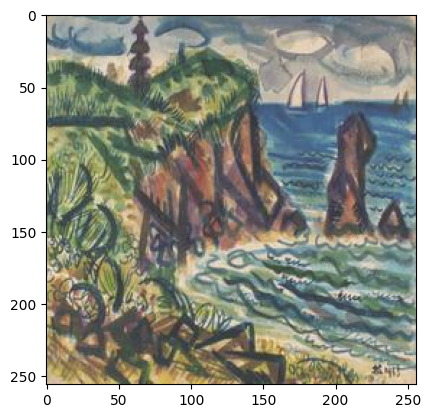

In [106]:
from matplotlib import pyplot as plt
plt.imshow(ngs)

In [107]:
from tensorflow.keras.applications.vgg16 import preprocess_input 


In [108]:
ngs_preproc = preprocess_input(loaded_images)

TypeError: list indices must be integers or slices, not tuple

In [94]:
for i in lst_filename[:10]:
    img_data = image.imread(os.path.join("../raw_data/aws10k_sm", i))
    x_ngs.append(img_data)
#     x_ngs.append(image)
#     x_ngs = np.array(x_ngs)

AttributeError: 'numpy.ndarray' object has no attribute 'imread'

In [ ]:
img_data = image.imread('images/' + filename)
	# store loaded image
	loaded_images.append(img_data)
	print('> loaded %s %s' % (filename, img_data.shape))

In [63]:
for file in lst_filename[0]:
    print(file)
#     image = Image.open(os.path.join("../raw_data/aws10k_sm", file))
#     imgs.append(np.array(image))
#     x_ngs = np.array(imgs)

2
0
0
3
-
0
3
4
7
4
.
j
p
g


In [ ]:
    for index, row in df.iterrows():
        img_file = str(row["filename"])
        image = Image.open(os.path.join(config.PATH_YOURPAINTINGS_SM, img_file))   
        imgs.append(np.array(image))
        X = np.array(imgs)
        X.shape
        y = df.drop(columns=['index', 'Image URL', 'Web page URL', 'Subset', 'Labels', 'filename', 'labels'])
        y.shape

In [8]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

In [10]:
df = pd.read_csv("../raw_data/df_10K.csv")

In [11]:
df

Unnamed: 0            id        0        1        2        3        4  \
0              0  2012-00335_t  #c6b089  #6f6457  #dfc499  #9f8871      NaN   
1              1  2010-01385_t  #656559  #d9bd3f  #383d37  #136949  #b0726b   
2              2  2015-00358_t  #ebb87e  #534332  #c59962  #8d6e47      NaN   
3              3  2002-00783_t  #aeafa7  #7f665e  #5c514e  #99887c      NaN   
4              4  2016-00456_t  #3d3a36  #e3dbd0  #857e74  #c1b9ae      NaN   
...          ...           ...      ...      ...      ...      ...      ...   
4374        4374  2015-00249_t  #56645c  #afb9ab  #938e7d  #39332b      NaN   
4375        4375  2012-00261_t  #484a49  #f0ece3  #80807d  #bbbbb6      NaN   
4376        4376  2009-03342_t  #dcceb8  #9d917e  #baae99  #827668      NaN   
4377        4377  2010-04023_t  #201c20  #c0ab92  #8b7059  #ae9478      NaN   
4378        4378  2016-00196_t  #202626  #627677  #394544  #151717      NaN   

        5  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
...   ...  
4374  NaN  
4375  NaN  
4376  NaN  
4377  NaN  
4378  NaN  

[4379 rows x 8 columns]

In [4]:
X, y = utils.load_data()

_request non-retriable exception: Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object., 401
Traceback (most recent call last):
  File "/Users/enjiaochen/.pyenv/versions/lewagon/lib/python3.8/site-packages/gcsfs/retry.py", line 115, in retry_request
    return await func(*args, **kwargs)
  File "/Users/enjiaochen/.pyenv/versions/lewagon/lib/python3.8/site-packages/gcsfs/core.py", line 384, in _request
    validate_response(status, contents, path, args)
  File "/Users/enjiaochen/.pyenv/versions/lewagon/lib/python3.8/site-packages/gcsfs/retry.py", line 102, in validate_response
    raise HttpError(error)
gcsfs.retry.HttpError: Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object., 401


HttpError: Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object., 401

In [40]:
df = pd.read_csv(Path("../raw_data/data_raw_data_df_yourpaintings.csv"))

In [12]:
def resize_rescale(source):
    '''Download images and resize to 256x256 if not already in local disk
    Args:
        source: df, local, cloud
    Returns:
    '''
#    df = pd.read_csv(config.PATH_FILE)
    if source == "df":
        for index, row in df.iterrows():
            img_file = str(row["filename"])
            image = Image.open(os.path.join(config.PATH_YOURPAINTINGS, img_file))
            image = image.resize((256, 256), Image.ANTIALIAS)
            image.save(os.path.join(config.PATH_YOURPAINTINGS_SM, img_file))
            #imgs.append(np.array(image/255))
    if source == "path":
        for file in os.listdir(PATH_NGS):
            image = Image.open(os.path.join(PATH_NGS, file))
            image = image.resize((256, 256), Image.ANTIALIAS)
            image.save(os.path.join(PATH_NGS_SM, file))
    return "Images resized and rescaled"

In [41]:
resize_rescale(source="df")

/var/folders/11/0smvrnys6yn2p6mvqskf9vxm0000gn/T/ipykernel_12159/27729670.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((256, 256), Image.ANTIALIAS)


'Images resized and rescaled'

In [18]:
def load_data():
    '''generates X and y'''
    '''read from disk or read from cloud <--- to be implemented'''
    
    imgs = []

    for file in os.listdir(PATH_NGS):
        image = Image.open(os.path.join(PATH_NGS_SM, file))   
        imgs.append(np.array(image))
        X = np.array(imgs)
        X.shape
    return X

In [21]:
X = load_data()
X = np.array(X)

In [20]:
X.shape

(10, 256, 256, 3)

In [22]:
pred = model.predict(X)

1/1 [==============================] - 2s 2s/step


In [24]:
pred[0]

array([0.24459508, 0.12576418, 0.06244959, 0.00660372, 0.04267118,
       0.01717522, 0.0298612 , 0.01034015, 0.08589564, 0.00666896],
      dtype=float32)

# Generate confusion matrix for model

In [37]:
df = pd.read_csv(Path("../raw_data/data_raw_data_df_yourpaintings.csv"))
df.columns

Index(['index', 'Image URL', 'Web page URL', 'Subset', 'Labels', 'filename',
       'labels', 'aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable',
       'dog', 'horse', 'sheep', 'train'],
      dtype='object')

In [42]:
def load_data():
    '''generates X and y'''
    '''read from disk or read from cloud <--- to be implemented'''
    df = pd.read_csv(Path("../raw_data/data_raw_data_df_yourpaintings.csv"))
    df
    imgs = []
    for index, row in df.iterrows():
        img_file = str(row["filename"])
        image = Image.open(os.path.join(config.PATH_YOURPAINTINGS_SM, img_file))   
        imgs.append(np.array(image))
        X = np.array(imgs)
        X.shape
        y = df.drop(columns=['index', 'Image URL', 'Web page URL', 'Subset', 'Labels', 'filename', 'labels'])
        y.shape
    return X, y

In [43]:
X, y = load_data()